# DataExtraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as Flatten
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn import metrics

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
!unzip '/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaCMATERdb/BanglaCharacterDataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/201/bcc000060.bmp  
  inflating: Dataset/Train/201/bcc000061.bmp  
  inflating: Dataset/Train/201/bcc000062.bmp  
  inflating: Dataset/Train/201/bcc000063.bmp  
  inflating: Dataset/Train/201/bcc000064.bmp  
  inflating: Dataset/Train/201/bcc000065.bmp  
  inflating: Dataset/Train/201/bcc000066.bmp  
  inflating: Dataset/Train/201/bcc000067.bmp  
  inflating: Dataset/Train/201/bcc000068.bmp  
  inflating: Dataset/Train/201/bcc000069.bmp  
  inflating: Dataset/Train/201/bcc000070.bmp  
  inflating: Dataset/Train/201/bcc000071.bmp  
  inflating: Dataset/Train/201/bcc000072.bmp  
  inflating: Dataset/Train/201/bcc000073.bmp  
  inflating: Dataset/Train/201/bcc000074.bmp  
  inflating: Dataset/Train/201/bcc000075.bmp  
  inflating: Dataset/Train/201/bcc000076.bmp  
  inflating: Dataset/Train/201/bcc000077.bmp  
  inflating: Dataset/Train/201/bcc000078.bmp  
  inflating: Dataset/Train/201/bcc000079.bmp  
  inflati

# After Extraction

In [ ]:
ROOT_DIR = '/content/Dataset'
TRAIN_ROOT = os.path.join(ROOT_DIR, 'Train')
TEST_ROOT = os.path.join(ROOT_DIR, 'Test')
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (32, 32)
BATCH_SIZE = 32

N_CLASSES = len(os.listdir(TRAIN_ROOT))

In [ ]:
paths = glob.glob('/content/Dataset/*/*/*.bmp')

df = pd.DataFrame({'Path': paths})

def extract_label(path):
    return int(path.split('/')[-2])

def extract_set(path):
    return path.split('/')[-3]

df['Label'] = df['Path'].apply(extract_label)
# df = pd.concat([df, pd.get_dummies(df['Label'])], axis = 1)

df['Set'] = df['Path'].apply(extract_set)

# train_df = df.loc[df['Set'] == 'Train'].iloc[:, :-1]
# test_df = df.loc[df['Set'] == 'Test'].iloc[:, :-1]

train_df = df.loc[df['Label'] >= 183].iloc[:, :-1]
# test_df = df.loc[df['Label'] < 183].iloc[:, :-1]
test_df = df.loc[df['Set'] == 'Test'].iloc[:, :-1]

In [ ]:
df

,Path,Label,Set
0,/content/Dataset/Test/191/bcc000052.bmp,191,Test
1,/content/Dataset/Test/191/bcc000053.bmp,191,Test
2,/content/Dataset/Test/191/bcc000007.bmp,191,Test
3,/content/Dataset/Test/191/bcc000035.bmp,191,Test
4,/content/Dataset/Test/191/bcc000034.bmp,191,Test
...,...,...,...
14995,/content/Dataset/Train/221/bcc000058.bmp,221,Train
14996,/content/Dataset/Train/221/bcc000142.bmp,221,Train
14997,/content/Dataset/Train/221/bcc000019.bmp,221,Train
14998,/content/Dataset/Train/221/bcc000010.bmp,221,Train


In [ ]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['Label'])], axis = 1)
train_df = train_df.reset_index(drop=True)
train_df

,Path,Label,183,184,185,186,187,188,189,190,...,212,213,214,215,216,217,218,219,220,221
0,/content/Dataset/Test/191/bcc000052.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/Dataset/Test/191/bcc000053.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/content/Dataset/Test/191/bcc000007.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/content/Dataset/Test/191/bcc000035.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/content/Dataset/Test/191/bcc000034.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11695,/content/Dataset/Train/221/bcc000058.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11696,/content/Dataset/Train/221/bcc000142.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11697,/content/Dataset/Train/221/bcc000019.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11698,/content/Dataset/Train/221/bcc000010.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['Label'])], axis = 1)
test_df = test_df.reset_index(drop=True)
test_df

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
0,/content/Dataset/Test/191/bcc000052.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/Dataset/Test/191/bcc000053.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/content/Dataset/Test/191/bcc000007.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/content/Dataset/Test/191/bcc000035.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/content/Dataset/Test/191/bcc000034.bmp,191,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,/content/Dataset/Test/221/bcc000045.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2996,/content/Dataset/Test/221/bcc000024.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2997,/content/Dataset/Test/221/bcc000058.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2998,/content/Dataset/Test/221/bcc000019.bmp,221,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


(81, 78, 3)


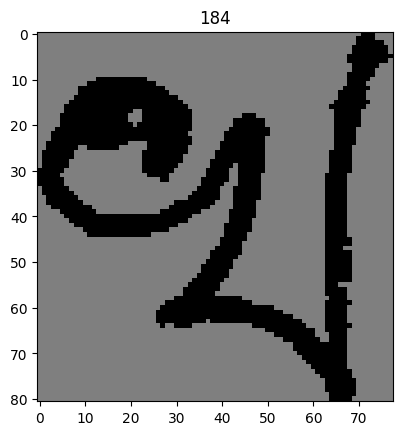

In [ ]:
import matplotlib.pyplot as plt
import random

def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['Path'][idx])
    label = train_df['Label'][idx]
    print(img.shape)
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

In [ ]:
class CustomDatasetLoader(torch.utils.data.Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)

        if self.transform:
            img = self.transform(img)

        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(IMG_SIZE),
    # torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)
# all_data = CustomDatasetLoader(df = df.iloc[:, :-1], transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 32, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)
# all_data_loader = torch.utils.data.DataLoader(
#     dataset = all_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
# )

In [ ]:
for (images, labels) in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32, 39])


In [ ]:
for (images, labels) in test_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64, 50])


# Pipeline

In [ ]:
def train(model, dataloader, embedding, criterion, optimizer, device):
    model.train()

    train_count, correct_predictions, train_loss = 0, 0, 0

    for (images, labels) in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        # _, labels = torch.max(labels.data, 1)

        predictions = model(images)
        predictions = torch.matmul(predictions.to(float), embedding)

        optimizer.zero_grad()
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(predictions.data, 1)
        _, labels = torch.max(labels.data, 1)

        train_count += labels.shape[0]
        correct_predictions += (predictions == labels).sum().item()
        train_loss += loss.item()

    train_acc = correct_predictions / train_count
    train_loss = train_loss / len(dataloader)

    return train_acc, train_loss

In [ ]:
def test(model, dataloader, embedding, criterion, device):
    model.eval()
    test_loss, test_count, correct_predictions = 0, 0, 0

    with torch.no_grad():
        for (images, labels) in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            predictions = model(images)
            predictions = torch.matmul(predictions.to(float), embedding)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            _, predictions = torch.max(predictions.data, 1)
            _, labels = torch.max(labels.data, 1)

            test_count += labels.shape[0]
            correct_predictions += (predictions == labels).sum().item()

        test_acc = correct_predictions / test_count
        test_loss = test_loss / len(dataloader)

    return test_acc, test_loss

In [ ]:
def eval_report(model, dataloader, embedding, device):
    model.eval()
    # test_count, correct_predictions = 0, 0

    preds, actuals = [], []

    with torch.no_grad():
        for (images, labels) in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            predictions = model(images)
            predictions = torch.matmul(predictions.to(float), embedding)

            _, predictions = torch.max(predictions.data, 1)
            _, labels = torch.max(labels.data, 1)

            for i in range(len(predictions)):
                preds.append(predictions[i].item())
                actuals.append(labels[i].item())

            # test_count += labels.shape[0]
            # correct_predictions += (predictions == labels).sum().item()

        # test_acc = correct_predictions / test_count

    # preds = torch.flatten(preds)
    # actuals = torch.flatten(actuals)

    acc = metrics.accuracy_score(y_true=actuals, y_pred=preds)
    pr = metrics.precision_score(y_true=actuals, y_pred=preds, average='micro')
    re = metrics.recall_score(y_true=actuals, y_pred=preds, average='micro')
    f1 = metrics.f1_score(y_true=actuals, y_pred=preds, average='micro')

    print(f"\nAccuracy : {acc*100:.2f}%")
    print(f"Precision: {pr:.4f}")
    print(f"Recall   : {re:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # return test_acc
    return preds, actuals

# Model

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, n_features=64, dropout=0.0):
        super(CustomCNN, self).__init__()
        self.relu = nn.ReLU()
        self.maxpool_k2xs1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        self.maxpool_k2xs2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv_dropout = nn.Dropout2d(p=dropout)
        self.fc_dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2, 2), stride=(1, 1), padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=(1, 1), padding=0)
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=n_features)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.batch_norm5 = nn.BatchNorm2d(256)

    def forward(self, img):
        img = self.conv_dropout(self.batch_norm1(self.maxpool_k2xs1(self.relu(self.conv1(img)))))
        img = self.conv_dropout(self.batch_norm2(self.maxpool_k2xs2(self.relu(self.conv2(img)))))
        img = self.conv_dropout(self.batch_norm3(self.maxpool_k2xs2(self.relu(self.conv3(img)))))
        img = self.conv_dropout(self.batch_norm4(self.maxpool_k2xs2(self.relu(self.conv4(img)))))
        img = self.conv_dropout(self.batch_norm5(self.relu(self.conv5(img))))
        img = img.reshape(img.shape[0], -1)
        img = self.fc_dropout(self.relu(self.fc1(img)))
        img = self.fc_dropout(self.relu(self.fc2(img)))
        img = self.out(img)
        return img

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)

sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

# Train-Validation-Test

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/BanglaCMATERdb/VAE/Embd_VAEResnet/embd_all_images_avg_df.csv')

# test_embedding = embedding.iloc[:, :11].values  # (64, 11)
test_embedding = embedding.iloc[:, :].values  # (64, 50)
train_embedding = embedding.iloc[:, 11:].values  # (64, 39)

train_embedding = torch.from_numpy(train_embedding)
test_embedding = torch.from_numpy(test_embedding)

train_embedding = train_embedding.to(DEVICE)
test_embedding = test_embedding.to(DEVICE)

train_embedding.shape, test_embedding.shape

(torch.Size([64, 39]), torch.Size([64, 50]))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(100+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, train_embedding, criterion, optimizer, DEVICE)
    test_acc, test_loss = test(model, test_loader, test_embedding, criterion, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%, Test Loss: {test_loss:.4f}\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if test_loss < best_loss and epoch != 0:
        best_acc = test_acc
        best_loss = test_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 20.66it/s]


Training Accuracy: 65.068%, Training Loss: 1.1521, Test Accuracy: 64.967%, Test Loss: 1.4788

Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 21.48it/s]


Training Accuracy: 85.402%, Training Loss: 0.4659, Test Accuracy: 62.833%, Test Loss: 1.8428

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 20.56it/s]


Training Accuracy: 90.068%, Training Loss: 0.3181, Test Accuracy: 65.400%, Test Loss: 2.2705

Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 20.72it/s]


Training Accuracy: 92.825%, Training Loss: 0.2305, Test Accuracy: 69.467%, Test Loss: 2.2390

Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 20.21it/s]


Training Accuracy: 94.452%, Training Loss: 0.1784, Test Accuracy: 64.600%, Test Loss: 2.6214

Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 15.77it/s]


Training Accuracy: 94.495%, Training Loss: 0.1725, Test Accuracy: 67.767%, Test Loss: 2.1844

Epoch: 6


100%|██████████| 47/47 [00:03<00:00, 15.49it/s]


Training Accuracy: 95.325%, Training Loss: 0.1447, Test Accuracy: 68.567%, Test Loss: 2.4019

Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 18.43it/s]


Training Accuracy: 95.616%, Training Loss: 0.1358, Test Accuracy: 72.167%, Test Loss: 2.1488

Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 21.28it/s]


Training Accuracy: 96.798%, Training Loss: 0.1041, Test Accuracy: 67.100%, Test Loss: 2.6451

Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 21.49it/s]


Training Accuracy: 96.002%, Training Loss: 0.1249, Test Accuracy: 68.267%, Test Loss: 3.0017

Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 22.03it/s]


Training Accuracy: 96.807%, Training Loss: 0.1027, Test Accuracy: 70.767%, Test Loss: 2.3634

Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 21.57it/s]


Training Accuracy: 97.192%, Training Loss: 0.0893, Test Accuracy: 69.867%, Test Loss: 2.6695

Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 21.11it/s]


Training Accuracy: 96.995%, Training Loss: 0.0980, Test Accuracy: 67.500%, Test Loss: 3.1562

Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 19.77it/s]


Training Accuracy: 97.534%, Training Loss: 0.0846, Test Accuracy: 68.200%, Test Loss: 3.4858

Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 16.56it/s]


Training Accuracy: 97.098%, Training Loss: 0.0960, Test Accuracy: 69.800%, Test Loss: 3.2873

Epoch: 15


100%|██████████| 47/47 [00:03<00:00, 15.03it/s]


Training Accuracy: 97.354%, Training Loss: 0.0899, Test Accuracy: 70.533%, Test Loss: 2.6367

Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 18.66it/s]


Training Accuracy: 97.654%, Training Loss: 0.0830, Test Accuracy: 67.733%, Test Loss: 3.5167

Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 21.14it/s]


Training Accuracy: 98.545%, Training Loss: 0.0469, Test Accuracy: 72.200%, Test Loss: 2.6424

Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 21.26it/s]


Training Accuracy: 97.680%, Training Loss: 0.0780, Test Accuracy: 70.133%, Test Loss: 2.5953

Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 21.01it/s]


Training Accuracy: 98.373%, Training Loss: 0.0537, Test Accuracy: 66.533%, Test Loss: 4.0915

Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 21.23it/s]


Training Accuracy: 98.433%, Training Loss: 0.0485, Test Accuracy: 69.800%, Test Loss: 3.4238

Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 21.59it/s]


Training Accuracy: 97.654%, Training Loss: 0.0868, Test Accuracy: 69.900%, Test Loss: 3.2246

Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 21.26it/s]


Training Accuracy: 97.945%, Training Loss: 0.0683, Test Accuracy: 68.333%, Test Loss: 3.5931

Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 18.57it/s]


Training Accuracy: 98.228%, Training Loss: 0.0620, Test Accuracy: 68.000%, Test Loss: 3.3085

Epoch: 24


100%|██████████| 47/47 [00:03<00:00, 15.29it/s]


Training Accuracy: 98.476%, Training Loss: 0.0574, Test Accuracy: 68.433%, Test Loss: 3.6372

Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 18.90it/s]


Training Accuracy: 98.193%, Training Loss: 0.0689, Test Accuracy: 67.800%, Test Loss: 3.3226

Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 21.35it/s]


Training Accuracy: 98.750%, Training Loss: 0.0396, Test Accuracy: 70.067%, Test Loss: 3.1953

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 22.30it/s]


Training Accuracy: 98.913%, Training Loss: 0.0396, Test Accuracy: 67.000%, Test Loss: 4.4697

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 21.62it/s]


Training Accuracy: 98.348%, Training Loss: 0.0629, Test Accuracy: 68.200%, Test Loss: 3.9513

Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 21.42it/s]


Training Accuracy: 98.716%, Training Loss: 0.0434, Test Accuracy: 69.600%, Test Loss: 3.7097

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 22.02it/s]


Training Accuracy: 98.716%, Training Loss: 0.0406, Test Accuracy: 68.133%, Test Loss: 3.7785

Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 17.97it/s]


Training Accuracy: 98.776%, Training Loss: 0.0449, Test Accuracy: 67.433%, Test Loss: 4.4137

Epoch: 32


100%|██████████| 47/47 [00:03<00:00, 15.02it/s]


Training Accuracy: 98.930%, Training Loss: 0.0398, Test Accuracy: 62.233%, Test Loss: 5.3825

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 19.59it/s]


Training Accuracy: 98.913%, Training Loss: 0.0389, Test Accuracy: 66.667%, Test Loss: 4.0554

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 21.76it/s]


Training Accuracy: 98.810%, Training Loss: 0.0447, Test Accuracy: 64.933%, Test Loss: 4.3403

Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 21.56it/s]


Training Accuracy: 98.699%, Training Loss: 0.0508, Test Accuracy: 63.033%, Test Loss: 5.0974

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 21.87it/s]


Training Accuracy: 98.998%, Training Loss: 0.0358, Test Accuracy: 65.433%, Test Loss: 4.6427

Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 21.53it/s]


Training Accuracy: 98.998%, Training Loss: 0.0359, Test Accuracy: 65.233%, Test Loss: 4.8956

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 21.90it/s]


Training Accuracy: 98.913%, Training Loss: 0.0424, Test Accuracy: 70.300%, Test Loss: 3.7267

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 17.33it/s]


Training Accuracy: 98.870%, Training Loss: 0.0386, Test Accuracy: 67.400%, Test Loss: 4.1170

Epoch: 40


100%|██████████| 47/47 [00:03<00:00, 15.23it/s]


Training Accuracy: 98.656%, Training Loss: 0.0479, Test Accuracy: 66.733%, Test Loss: 4.9181

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 19.89it/s]


Training Accuracy: 99.272%, Training Loss: 0.0302, Test Accuracy: 63.700%, Test Loss: 5.5407

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 20.48it/s]


Training Accuracy: 99.247%, Training Loss: 0.0250, Test Accuracy: 66.233%, Test Loss: 5.1904

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 21.63it/s]


Training Accuracy: 98.836%, Training Loss: 0.0540, Test Accuracy: 65.833%, Test Loss: 4.0410

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 21.72it/s]


Training Accuracy: 99.341%, Training Loss: 0.0270, Test Accuracy: 66.800%, Test Loss: 5.3314

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 21.63it/s]


Training Accuracy: 99.041%, Training Loss: 0.0383, Test Accuracy: 68.467%, Test Loss: 4.5885

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 21.46it/s]


Training Accuracy: 99.461%, Training Loss: 0.0247, Test Accuracy: 68.800%, Test Loss: 3.8177

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 19.90it/s]


Training Accuracy: 98.801%, Training Loss: 0.0461, Test Accuracy: 69.733%, Test Loss: 4.0849

Epoch: 48


100%|██████████| 47/47 [00:03<00:00, 15.33it/s]


Training Accuracy: 99.135%, Training Loss: 0.0351, Test Accuracy: 69.600%, Test Loss: 4.1816

Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 17.78it/s]


Training Accuracy: 99.247%, Training Loss: 0.0299, Test Accuracy: 70.567%, Test Loss: 3.4965

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 22.14it/s]


Training Accuracy: 99.212%, Training Loss: 0.0305, Test Accuracy: 69.367%, Test Loss: 4.3305

Epoch: 51


100%|██████████| 47/47 [00:02<00:00, 21.79it/s]


Training Accuracy: 98.947%, Training Loss: 0.0420, Test Accuracy: 68.867%, Test Loss: 3.4205

Epoch: 52


100%|██████████| 47/47 [00:02<00:00, 21.40it/s]


Training Accuracy: 99.247%, Training Loss: 0.0335, Test Accuracy: 67.733%, Test Loss: 4.3003

Epoch: 53


100%|██████████| 47/47 [00:02<00:00, 21.52it/s]


Training Accuracy: 99.461%, Training Loss: 0.0169, Test Accuracy: 67.567%, Test Loss: 4.2791

Epoch: 54


100%|██████████| 47/47 [00:02<00:00, 21.73it/s]


Training Accuracy: 98.930%, Training Loss: 0.0343, Test Accuracy: 67.200%, Test Loss: 4.7463

Epoch: 55


100%|██████████| 47/47 [00:02<00:00, 20.18it/s]


Training Accuracy: 99.187%, Training Loss: 0.0329, Test Accuracy: 67.333%, Test Loss: 4.1435

Epoch: 56


100%|██████████| 47/47 [00:03<00:00, 15.29it/s]


Training Accuracy: 99.238%, Training Loss: 0.0356, Test Accuracy: 66.533%, Test Loss: 4.3208

Epoch: 57


100%|██████████| 47/47 [00:02<00:00, 17.67it/s]


Training Accuracy: 99.375%, Training Loss: 0.0236, Test Accuracy: 66.067%, Test Loss: 4.7542

Epoch: 58


100%|██████████| 47/47 [00:02<00:00, 21.58it/s]


Training Accuracy: 99.075%, Training Loss: 0.0387, Test Accuracy: 66.700%, Test Loss: 4.5471

Epoch: 59


100%|██████████| 47/47 [00:02<00:00, 21.57it/s]


Training Accuracy: 99.486%, Training Loss: 0.0200, Test Accuracy: 67.333%, Test Loss: 4.4370

Epoch: 60


100%|██████████| 47/47 [00:02<00:00, 21.90it/s]


Training Accuracy: 99.272%, Training Loss: 0.0299, Test Accuracy: 66.800%, Test Loss: 4.5920

Epoch: 61


100%|██████████| 47/47 [00:02<00:00, 21.31it/s]


Training Accuracy: 99.512%, Training Loss: 0.0184, Test Accuracy: 65.400%, Test Loss: 4.9781

Epoch: 62


100%|██████████| 47/47 [00:02<00:00, 20.55it/s]


Training Accuracy: 99.349%, Training Loss: 0.0257, Test Accuracy: 65.400%, Test Loss: 4.8825

Epoch: 63


100%|██████████| 47/47 [00:02<00:00, 19.04it/s]


Training Accuracy: 99.409%, Training Loss: 0.0222, Test Accuracy: 67.833%, Test Loss: 4.4923

Epoch: 64


100%|██████████| 47/47 [00:03<00:00, 14.81it/s]


Training Accuracy: 98.990%, Training Loss: 0.0419, Test Accuracy: 68.433%, Test Loss: 4.0608

Epoch: 65


100%|██████████| 47/47 [00:02<00:00, 18.08it/s]


Training Accuracy: 99.187%, Training Loss: 0.0373, Test Accuracy: 66.600%, Test Loss: 4.1232

Epoch: 66


100%|██████████| 47/47 [00:02<00:00, 21.94it/s]


Training Accuracy: 99.486%, Training Loss: 0.0210, Test Accuracy: 66.867%, Test Loss: 4.9284

Epoch: 67


100%|██████████| 47/47 [00:02<00:00, 20.71it/s]


Training Accuracy: 99.435%, Training Loss: 0.0233, Test Accuracy: 67.233%, Test Loss: 4.3998

Epoch: 68


100%|██████████| 47/47 [00:02<00:00, 21.64it/s]


Training Accuracy: 99.307%, Training Loss: 0.0310, Test Accuracy: 66.600%, Test Loss: 5.0282

Epoch: 69


100%|██████████| 47/47 [00:02<00:00, 22.09it/s]


Training Accuracy: 99.409%, Training Loss: 0.0260, Test Accuracy: 66.333%, Test Loss: 4.8299

Epoch: 70


100%|██████████| 47/47 [00:02<00:00, 21.39it/s]


Training Accuracy: 99.392%, Training Loss: 0.0245, Test Accuracy: 65.600%, Test Loss: 4.7973

Epoch: 71


100%|██████████| 47/47 [00:02<00:00, 19.46it/s]


Training Accuracy: 99.409%, Training Loss: 0.0267, Test Accuracy: 62.633%, Test Loss: 6.4026

Epoch: 72


100%|██████████| 47/47 [00:03<00:00, 15.24it/s]


Training Accuracy: 98.904%, Training Loss: 0.0479, Test Accuracy: 65.300%, Test Loss: 5.7924

Epoch: 73


100%|██████████| 47/47 [00:02<00:00, 17.65it/s]


Training Accuracy: 99.384%, Training Loss: 0.0291, Test Accuracy: 66.467%, Test Loss: 5.2549

Epoch: 74


100%|██████████| 47/47 [00:02<00:00, 21.40it/s]


Training Accuracy: 99.572%, Training Loss: 0.0188, Test Accuracy: 64.900%, Test Loss: 6.9745

Epoch: 75


100%|██████████| 47/47 [00:02<00:00, 22.21it/s]


Training Accuracy: 99.598%, Training Loss: 0.0187, Test Accuracy: 65.733%, Test Loss: 5.9423

Epoch: 76


100%|██████████| 47/47 [00:02<00:00, 21.28it/s]


Training Accuracy: 99.324%, Training Loss: 0.0315, Test Accuracy: 62.967%, Test Loss: 6.2843

Epoch: 77


100%|██████████| 47/47 [00:02<00:00, 20.93it/s]


Training Accuracy: 99.315%, Training Loss: 0.0309, Test Accuracy: 64.400%, Test Loss: 5.8437

Epoch: 78


100%|██████████| 47/47 [00:02<00:00, 21.85it/s]


Training Accuracy: 99.503%, Training Loss: 0.0251, Test Accuracy: 65.433%, Test Loss: 6.1627

Epoch: 79


100%|██████████| 47/47 [00:02<00:00, 19.79it/s]


Training Accuracy: 99.563%, Training Loss: 0.0205, Test Accuracy: 65.367%, Test Loss: 5.5454

Epoch: 80


100%|██████████| 47/47 [00:03<00:00, 15.62it/s]


Training Accuracy: 99.443%, Training Loss: 0.0191, Test Accuracy: 66.100%, Test Loss: 6.4112

Epoch: 81


100%|██████████| 47/47 [00:02<00:00, 17.66it/s]


Training Accuracy: 99.700%, Training Loss: 0.0106, Test Accuracy: 65.300%, Test Loss: 6.6973

Epoch: 82


100%|██████████| 47/47 [00:02<00:00, 21.25it/s]


Training Accuracy: 99.426%, Training Loss: 0.0254, Test Accuracy: 65.733%, Test Loss: 6.5694

Epoch: 83


100%|██████████| 47/47 [00:02<00:00, 21.72it/s]


Training Accuracy: 99.358%, Training Loss: 0.0271, Test Accuracy: 64.133%, Test Loss: 6.1064

Epoch: 84


100%|██████████| 47/47 [00:02<00:00, 21.80it/s]


Training Accuracy: 99.409%, Training Loss: 0.0295, Test Accuracy: 64.433%, Test Loss: 6.5295

Epoch: 85


100%|██████████| 47/47 [00:02<00:00, 21.86it/s]


Training Accuracy: 99.443%, Training Loss: 0.0253, Test Accuracy: 64.267%, Test Loss: 7.5655

Epoch: 86


100%|██████████| 47/47 [00:02<00:00, 21.84it/s]


Training Accuracy: 99.247%, Training Loss: 0.0331, Test Accuracy: 65.233%, Test Loss: 5.9189

Epoch: 87


100%|██████████| 47/47 [00:02<00:00, 21.23it/s]


Training Accuracy: 99.418%, Training Loss: 0.0230, Test Accuracy: 65.633%, Test Loss: 6.1090

Epoch: 88


100%|██████████| 47/47 [00:02<00:00, 16.58it/s]


Training Accuracy: 99.486%, Training Loss: 0.0218, Test Accuracy: 66.200%, Test Loss: 6.2532

Epoch: 89


100%|██████████| 47/47 [00:02<00:00, 16.69it/s]


Training Accuracy: 99.649%, Training Loss: 0.0158, Test Accuracy: 66.000%, Test Loss: 6.2321

Epoch: 90


100%|██████████| 47/47 [00:02<00:00, 22.09it/s]


Training Accuracy: 99.632%, Training Loss: 0.0149, Test Accuracy: 66.033%, Test Loss: 5.5462

Epoch: 91


100%|██████████| 47/47 [00:02<00:00, 21.66it/s]


Training Accuracy: 99.623%, Training Loss: 0.0154, Test Accuracy: 65.500%, Test Loss: 8.2379

Epoch: 92


100%|██████████| 47/47 [00:02<00:00, 21.96it/s]


Training Accuracy: 99.495%, Training Loss: 0.0213, Test Accuracy: 65.200%, Test Loss: 7.7897

Epoch: 93


100%|██████████| 47/47 [00:02<00:00, 21.98it/s]


Training Accuracy: 99.580%, Training Loss: 0.0167, Test Accuracy: 65.867%, Test Loss: 6.5179

Epoch: 94


100%|██████████| 47/47 [00:02<00:00, 21.55it/s]


Training Accuracy: 99.538%, Training Loss: 0.0210, Test Accuracy: 66.400%, Test Loss: 7.0132

Epoch: 95


100%|██████████| 47/47 [00:02<00:00, 20.80it/s]


Training Accuracy: 99.623%, Training Loss: 0.0148, Test Accuracy: 65.833%, Test Loss: 7.3305

Epoch: 96


100%|██████████| 47/47 [00:02<00:00, 16.32it/s]


Training Accuracy: 99.563%, Training Loss: 0.0248, Test Accuracy: 62.100%, Test Loss: 7.6425

Epoch: 97


100%|██████████| 47/47 [00:02<00:00, 17.32it/s]


Training Accuracy: 99.435%, Training Loss: 0.0289, Test Accuracy: 63.700%, Test Loss: 6.5251

Epoch: 98


100%|██████████| 47/47 [00:02<00:00, 21.86it/s]


Training Accuracy: 99.512%, Training Loss: 0.0196, Test Accuracy: 64.200%, Test Loss: 5.9873

Epoch: 99


100%|██████████| 47/47 [00:02<00:00, 22.28it/s]


Training Accuracy: 99.640%, Training Loss: 0.0147, Test Accuracy: 62.200%, Test Loss: 6.5995

Epoch: 100


100%|██████████| 47/47 [00:02<00:00, 21.70it/s]

Training Accuracy: 99.580%, Training Loss: 0.0222, Test Accuracy: 64.967%, Test Loss: 6.1405



# Report

In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

preds, labels = eval_report(model, test_loader, test_embedding, DEVICE)

100%|██████████| 47/47 [00:02<00:00, 21.75it/s]



Accuracy : 62.83%
Precision: 0.6283
Recall   : 0.6283
F1 Score : 0.6283
